In [467]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from lorenz_gan.submodels import SubModelANN, SubModelPoly, AR1RandomUpdater
from keras.models import Model, load_model
import keras.backend as K
from keras.layers import Dense, Activation, Input, BatchNormalization, Dropout, concatenate, GaussianNoise, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2
from lorenz_gan.gan import Interpolate1D, unnormalize_data, normalize_data, ConcreteDropout, AlphaDropout
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import xarray as xr

In [15]:
trends = pd.read_csv("multiTimeline.csv", skiprows=1, index_col="Month", parse_dates=["Month"])

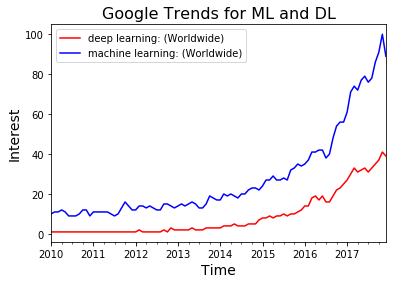

In [29]:
trends.plot(figsize=(6, 4), color=["red", "blue"])
plt.xlabel("Time", fontsize=14)
plt.ylabel("Interest", fontsize=14)
plt.title("Google Trends for ML and DL", fontsize=16)
plt.savefig("ml_interest_trends.png", dpi=200, bbox_inches="tight")

In [4]:
lorenz_data = pd.read_csv("../exp_u/lorenz_combined_output.csv")

In [57]:
y_cols = lorenz_data.columns[lorenz_data.columns.str.contains("Y")]


In [408]:
class SubModelANN(object):
    def __init__(self, inputs=1, hidden_layers=2, hidden_neurons=8,
                 activation="selu", l2_weight=0.01, learning_rate=0.001, loss="mse",
                 noise_sd=1, beta_1=0.9, model_path=None, dropout_alpha=0.5,
                 num_epochs=10, batch_size=1024, verbose=0, model_config=0):
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.l2_weight = l2_weight
        self.learning_rate = learning_rate
        self.loss = loss
        self.beta_1 = beta_1
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_config = model_config

        if model_path is None:
            nn_input = Input((inputs, ))
            nn_model = nn_input
            for h in range(hidden_layers):
                nn_model = Dense(hidden_neurons, kernel_regularizer=l2(l2_weight))(nn_model)
                if activation == "leaky":
                    nn_model = LeakyReLU(0.1)(nn_model)
                else:
                    nn_model = Activation(activation)(nn_model)
                nn_model = Dropout(dropout_alpha)(nn_model)
                nn_model = GaussianNoise(noise_sd)(nn_model)
            nn_model = Dense(1)(nn_model)
            self.model = Model(nn_input, nn_model)
            self.model.compile(Adam(lr=learning_rate, beta_1=beta_1), loss=loss)
            self.x_scaling_file = None
            self.x_scaling_values = None
        elif type(model_path) == str:
            self.model = load_model(model_path)
            model_path_start = join(model_path.split("/")[:-1])
            self.x_scaling_file = join(model_path_start, "gan_X_scaling_values_{0}.csv".format(self.model_config))
            self.x_scaling_values = pd.read_csv(self.x_scaling_file, index_col="Channel")

    def fit(self, cond_x, u):
        norm_x, self.x_scaling_values = normalize_data(np.expand_dims(cond_x, 1),
                                                       scaling_values=self.x_scaling_values)
        self.model.fit(norm_x[:, :, 0], u, batch_size=self.batch_size, epochs=self.num_epochs, verbose=self.verbose)

    def predict(self, cond_x):
        norm_x = normalize_data(np.expand_dims(cond_x, axis=2), scaling_values=self.x_scaling_values)[0][:, :, 0]
        sample_predict = K.function([self.model.input, K.learning_phase()], [self.model.output])
        sampled_u = sample_predict([norm_x, 1])[0]
        return sampled_u.ravel()

In [146]:
u_vals = lorenz_data[y_cols].sum(axis=1)

In [409]:
ann = SubModelANN(inputs=1, hidden_layers=2, hidden_neurons=12, batch_size=512, 
                  activation="leaky", verbose=1, noise_sd=1.99, dropout_alpha=0.4)
ann.fit(lorenz_data[["X_t"]].values, u_vals)
ann_preds = ann.predict(lorenz_data[["X_t"]].values)
ann_res = ann_preds - u_vals
print(ann_res.std())

Epoch 1/10
319680/319680 [==============================] - 3s - loss: 38.1605     
Epoch 2/10
319680/319680 [==============================] - 2s - loss: 22.5936     
Epoch 3/10
319680/319680 [==============================] - 2s - loss: 18.1208     
Epoch 4/10
319680/319680 [==============================] - 3s - loss: 16.1677     
Epoch 5/10
319680/319680 [==============================] - 2s - loss: 14.9780     
Epoch 6/10
319680/319680 [==============================] - 3s - loss: 14.1466     
Epoch 7/10
319680/319680 [==============================] - 3s - loss: 13.6237     
Epoch 8/10
319680/319680 [==============================] - 3s - loss: 13.2509     
Epoch 9/10
319680/319680 [==============================] - 3s - loss: 12.9984     
Epoch 10/10
319680/319680 [==============================] - 3s - loss: 12.8064     
3.4025975265713773


(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-20.69958887, -20.20917255, -19.71875624, -19.22833993,
        -18.73792362, -18.2475073 , -17.75709099, -17.26667468,
        -16.77625836, -16.28584205, -15.79542574, -15.30500942,
        -14.81459311, -14.3241768 , -13.83376049, -13.34334417,
        -12.85292786, -12.36251155, -11.87209523, -11.38167892,
        -10.89126261, -10.40084629,  -9.91042998,  -9.42001367,
         -8.92959735,  -8.43918104,  -7.94876473,  -7.45834842,
         -6.9679321 ,  -6.47751579,  -5.98709948,  -5.49668316,
         -5.00626685,  -4.51585054,  -4.02543422,  -3.53501791,
         -3.0446016 ,  -2.55418529,  -2.06376897,  -1.57335266,
         -1.08293635,  -0.59252003,  -0.10210372,   0.38831259,
          

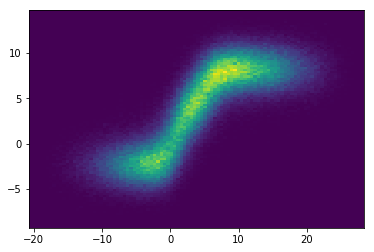

In [380]:
plt.hist2d(lorenz_data["X_t"], ann_preds, 100)

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


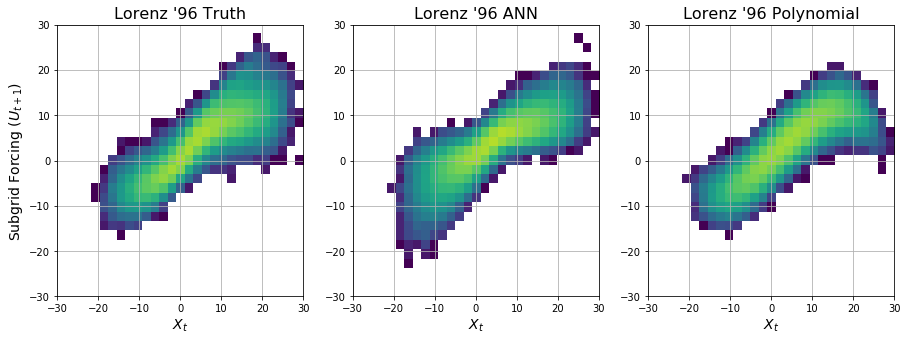

In [410]:
epoch = 10
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = axes[0].hist2d(lorenz_data["X_t"], lorenz_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(lorenz_data["X_t"], ann_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
_ = axes[2].hist2d(lorenz_data["X_t"], poly_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[1].set_title("Lorenz '96 ANN".format(epoch), fontsize=16)
axes[2].set_title("Lorenz '96 Polynomial".format(epoch), fontsize=16)

for a in range(3):
    axes[a].set_xlabel("$X_t$", fontsize=14)
    axes[a].grid()
axes[0].set_ylabel("Subgrid Forcing ($U_{t+1}$)", fontsize=14)
#plt.savefig("../exp_u/gan_x_u_hist_epoch_{0}.png".format(epoch), dpi=200, bbox_inches="tight")

In [396]:
poly_det = SubModelPoly(num_terms=3, noise_type="det")
poly_det.fit(lorenz_data["X_t"].values, lorenz_data[y_cols].sum(axis=1))
poly_det_preds = poly_det.predict(lorenz_data[["X_t"]], np.zeros(lorenz_data["X_t"].shape))

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


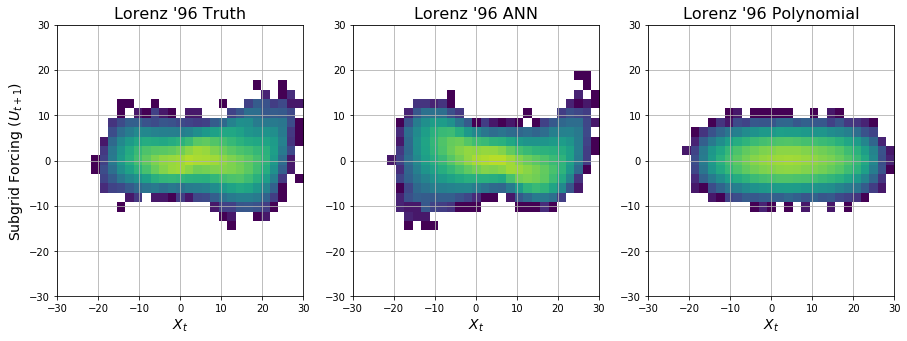

In [411]:
epoch = 10
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = axes[0].hist2d(lorenz_data["X_t"], lorenz_data[y_cols].sum(axis=1) - poly_det_preds, bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(lorenz_data["X_t"], ann_preds - poly_det_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
_ = axes[2].hist2d(lorenz_data["X_t"], poly_preds - poly_det_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[1].set_title("Lorenz '96 ANN".format(epoch), fontsize=16)
axes[2].set_title("Lorenz '96 Polynomial".format(epoch), fontsize=16)

for a in range(3):
    axes[a].set_xlabel("$X_t$", fontsize=14)
    axes[a].grid()
axes[0].set_ylabel("Subgrid Forcing ($U_{t+1}$)", fontsize=14)

In [414]:
lorenz_data["X_t"]

0          5.660486
1          7.336052
2          9.120433
3         10.972782
4         12.816656
5         14.340380
6         14.885148
7         13.635075
8         10.134742
9          4.575421
10        -1.596682
11        -6.586914
12        -9.248610
13        -9.347356
14        -7.367540
15        -4.063402
16        -0.180645
17         3.407572
18         6.054032
19         7.512947
20         7.825229
21         7.227141
22         6.102857
23         4.849446
24         3.831691
25         3.196273
26         2.925023
27         2.917089
28         3.039210
29         3.254492
            ...    
319650    -0.314222
319651     1.275392
319652     2.625272
319653     3.655131
319654     4.159126
319655     3.879882
319656     2.731074
319657     1.196170
319658     0.319069
319659     0.839592
319660     2.298748
319661     3.114654
319662     1.982095
319663    -1.201959
319664    -5.257030
319665    -8.269689
319666    -8.760392
319667    -6.832932
319668    -3.908874


In [424]:
bins = np.arange(-30, 32, 2)
res_sds = np.zeros(bins.shape[0] - 1)
res_values = lorenz_data[y_cols].sum(axis=1).values - ann_preds
for b, bin_val in enumerate(bins[:-1]):
    idxs = np.where((lorenz_data["X_t"].values >=bin_val) & (lorenz_data["X_t"].values < bins[b + 1]))[0]
    if len(idxs) > 0:
        res_sds[b] = res_values[idxs].std()

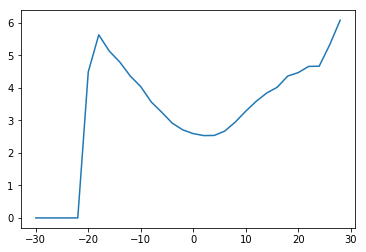

In [425]:
plt.plot(bins[:-1], res_sds)

In [142]:
poly_res = poly_det_preds - lorenz_data[y_cols].sum(axis=1)
poly_res.std()

2.3337782171445993

In [143]:
rand_x = norm.rvs(scale=poly_res.std(), size=lorenz_data[["X_t"]].shape)
poly = SubModelPoly(num_terms=3, noise_type="additive")
poly.fit(lorenz_data["X_t"].values, lorenz_data[y_cols].sum(axis=1))
poly_preds = poly.predict(lorenz_data[["X_t"]], rand_x)

In [128]:
poly_mult = SubModelPoly(num_terms=3, noise_type="multiplicative")
poly_mult.fit(lorenz_data["X_t"].values, lorenz_data[y_cols].sum(axis=1))
poly_mult_preds = poly_mult.predict(lorenz_data[["X_t"]], rand_x)

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


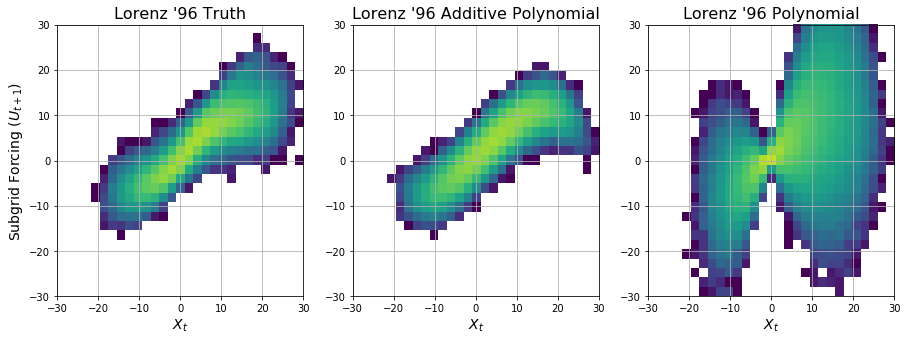

In [145]:
epoch = 10
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = axes[0].hist2d(lorenz_data["X_t"], lorenz_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(lorenz_data["X_t"], poly_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
_ = axes[2].hist2d(lorenz_data["X_t"], poly_mult_preds, bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
axes[1].set_title("Lorenz '96 Additive Polynomial".format(epoch), fontsize=16)
axes[2].set_title("Lorenz '96 Polynomial".format(epoch), fontsize=16)

for a in range(3):
    axes[a].set_xlabel("$X_t$", fontsize=14)
    axes[a].grid()
axes[0].set_ylabel("Subgrid Forcing ($U_{t+1}$)", fontsize=14)

In [123]:
truth_data = xr.open_dataset("../exp_u/lorenz_output.nc")
truth_data["lorenz_x"][:, 0]

<xarray.DataArray 'lorenz_x' (time: 399600)>
[399600 values with dtype=float64]
Coordinates:
  * time     (time) float64 2.0 2.005 2.01 2.015 2.02 2.025 2.03 2.035 2.04 ...
    x        int64 0
Attributes:
    units:      
    long_name:  lorenz_x

In [124]:
ar1 = AR1RandomUpdater()
ar1.fit(truth_data["lorenz_x"][:, 0])

In [127]:
ar1.corr

0.99852411747413328

In [163]:
x_row = truth_data["lorenz_x"][:, 0].values

In [186]:
poly_x = poly_det.predict(x_row.reshape(-1,1), np.zeros(x_row.shape))
poly_res = poly_x - x_row

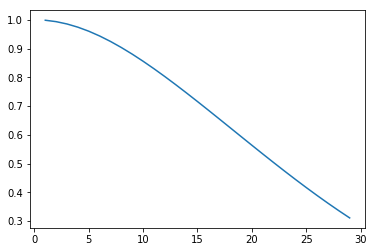

In [184]:
shifts = np.arange(1, 30)
corrs = np.zeros(shifts.shape)
for s, shift in enumerate(shifts):
    corrs[s] = pd.Series(x_row - poly_x).autocorr(shift)
plt.plot(shifts, corrs)

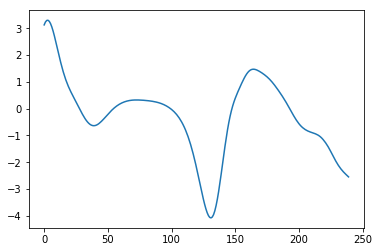

In [191]:
plt.plot(poly_res[60: 300])

In [445]:
res_net_det = Input((1,))
res_net = Dense(6)(res_net_det)
res_net = Activation("selu")(res_net)
res_net = Dropout(0.5)(res_net)
res_net = GaussianNoise(1)(res_net)
res_net = Dense(6)(res_net)
res_net = Activation("selu")(res_net)
res_net = Dropout(0.5)(res_net)
res_net = GaussianNoise(1)(res_net)
res_net = Dense(3)(res_net)
res_net_model = Model(res_net_det, res_net)
res_net_model.compile("adam", "mse")
print(res_net_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_146 (Dense)            (None, 6)                 12        
_________________________________________________________________
activation_90 (Activation)   (None, 6)                 0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 6)                 0         
_________________________________________________________________
gaussian_noise_21 (GaussianN (None, 6)                 0         
_________________________________________________________________
dense_147 (Dense)            (None, 6)                 42        
_________________________________________________________________
activation_91 (Activation)   (None, 6)                 0         
__________

In [310]:
outputs = np.zeros((poly_res.shape[0] - 6, 3))
for i in range(poly_res.shape[0] - 6):
    outputs[i] = poly_res[i+1:i+4]
    

In [321]:
res_net_model.layers[-4].get_weights()

[array([[ 0.20663193, -0.34509084,  0.23296945],
        [ 0.46442187, -0.00123744, -0.31755602]], dtype=float32),
 array([ 2.20410872,  1.96106398,  2.90702581], dtype=float32)]

In [446]:

res_net_model.fit(np.expand_dims(poly_res[:-6], axis=-1), outputs, batch_size=256, epochs=15)

Epoch 1/15
399594/399594 [==============================] - 6s - loss: 6.1414     
Epoch 2/15
399594/399594 [==============================] - 5s - loss: 3.1357     
Epoch 3/15
399594/399594 [==============================] - 6s - loss: 2.9551     
Epoch 4/15
399594/399594 [==============================] - 6s - loss: 2.9169     
Epoch 5/15
399594/399594 [==============================] - 6s - loss: 2.8955     
Epoch 6/15
399594/399594 [==============================] - 6s - loss: 2.8887     
Epoch 7/15
399594/399594 [==============================] - 6s - loss: 2.8715     
Epoch 8/15
399594/399594 [==============================] - 7s - loss: 2.8637     
Epoch 9/15
399594/399594 [==============================] - 6s - loss: 2.8656     
Epoch 10/15
399594/399594 [==============================] - 7s - loss: 2.8460     
Epoch 11/15
399594/399594 [==============================] - 7s - loss: 2.8796     
Epoch 12/15
399594/399594 [==============================] - 8s - loss: 2.8582     
E

In [447]:
stoch_pred = K.function([res_net_model.input, K.learning_phase()], [res_net_model.output])
num_preds = 1000
inputs = np.arange(-3, 4)
stoch_outputs = pd.DataFrame(index=np.arange(num_preds), columns=inputs, dtype=float)
for i, in_val in enumerate(inputs):
    for n in range(num_preds):
        stoch_outputs.iloc[n, i] = stoch_pred([np.array([[in_val]]), 1])[0][0,0]

In [348]:
def ar1_pred(x):
    corr = 0.986
    sd = 1.99
    return corr * x + sd * (1 - corr ** 2) ** 0.5 * norm.rvs() 

num_preds = 1000
inputs = np.arange(-3, 4)
ar1_outputs = pd.DataFrame(index=np.arange(num_preds), columns=inputs, dtype=float)
for i, in_val in enumerate(inputs):
    for n in range(num_preds):
        ar1_outputs.iloc[n, i] = ar1_pred(in_val)

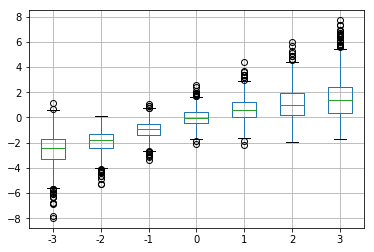

In [448]:
stoch_outputs.boxplot()

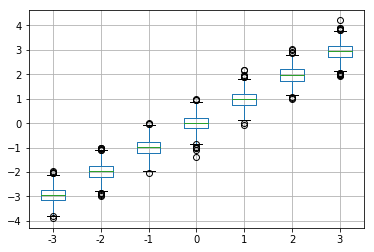

In [449]:
ar1_outputs.boxplot()

In [304]:
1.99 * (1 - .986**2) ** 0.5 * 6

1.9909390584344886

In [297]:
(1 - .986**2) ** 0.5

0.16674531477675783

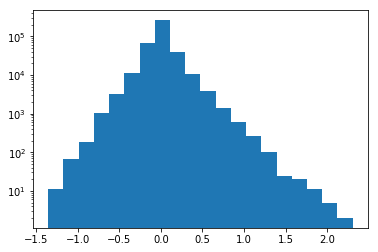

In [270]:
plt.hist(poly_res[1:] - poly_res[:-1], 20)
plt.gca().set_yscale("log")

(array([  1.92000000e+02,   9.86000000e+02,   5.00100000e+03,
          1.40220000e+04,   4.68960000e+04,   2.79986000e+05,
          4.96490000e+04,   2.70100000e+03,   1.46000000e+02,
          2.10000000e+01]),
 array([-21.63609865, -17.78862082, -13.941143  , -10.09366518,
         -6.24618736,  -2.39870953,   1.44876829,   5.29624611,
          9.14372393,  12.99120176,  16.83867958]),
 <a list of 10 Patch objects>)

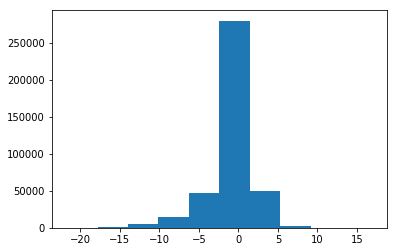

In [277]:
plt.hist(poly_res)

In [438]:
d = np.arange(12).reshape(3, 2, 2)
e = np.arange(6).reshape(3, 2)

In [436]:
d[...,1]

array([[ 1,  3],
       [ 5,  7],
       [ 9, 11]])

In [437]:
d[:, :, 1]

array([[ 1,  3],
       [ 5,  7],
       [ 9, 11]])

In [440]:
e[..., 1]

array([1, 3, 5])

In [441]:

def normalize_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[..., i].mean(), data[..., i].std()]
        normed_data[..., i] = (data[..., i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values

In [443]:
normalize_data(lorenz_data[["X_t", "Y_0"]].values)

(array([[ 0.15128956,  0.12136815],
        [ 0.37043042,  0.21728672],
        [ 0.6038028 ,  0.06905788],
        ..., 
        [-0.29737703, -0.10655046],
        [-0.49097631,  0.39805333],
        [-0.75075352,  0.42724461]]),        mean       std
 0  4.503716  7.646068
 1  0.086921  0.386131)

In [450]:
import yaml
test_dict = {"a":5, "b":3.2, "c":"bob"}
out = open("test_file.yml", "w")
yaml.dump(test_dict, out)
out.close()

In [451]:
out2 = open("test_file.yml")
new_dict = yaml.load(out2)
out2.close()

In [452]:
new_dict

{'a': 5, 'b': 3.2, 'c': 'bob'}

In [548]:
class SubModelPolyAdd(object):
    def __init__(self, num_terms=3):
        self.num_terms = num_terms
        self.model = LinearRegression()
        self.res_sd = 0
        self.corr = 1

    def fit(self, x_col, u):
        x_terms = np.zeros((x_col.shape[0], self.num_terms))
        for p in range(1, self.num_terms + 1):
            x_terms[:, p - 1] = x_col ** p
        self.model.fit(x_terms, u)
        u_mean = self.model.predict(x_terms)
        residuals = u - u_mean
        self.corr = np.corrcoef(residuals[1:], residuals[:-1])[0, 1]
        self.res_sd = np.std(residuals)

    def predict(self, x, residuals=None):
        if residuals is None:
            residuals = np.zeros(x.shape[0])
        x_terms = np.zeros((x.shape[0], self.num_terms))
        for p in range(1, self.num_terms + 1):
            x_terms[:, p - 1] = x ** p
        u_mean = self.model.predict(x_terms)
        u_res = self.corr * residuals + \
            self.res_sd * np.sqrt(1 - self.corr ** 2) * np.random.normal(size=residuals.shape)
        return u_mean, u_res
    
class SubModelANNRes(object):
    def __init__(self, mean_inputs=1, res_inputs=2, hidden_layers=2, hidden_neurons=8,
                 activation="selu", l2_weight=0.01, learning_rate=0.001, loss="mse",
                 noise_sd=1, beta_1=0.9, model_path=None, dropout_alpha=0.5,
                 num_epochs=10, batch_size=1024, verbose=0, model_config=0):
        self.config = dict(mean_inputs=mean_inputs,
                           res_inputs=res_inputs,
                           hidden_layers=hidden_layers,
                           hidden_neurons=hidden_neurons,
                           activation=activation,
                           l2_weight=l2_weight,
                           learning_rate=learning_rate,
                           loss=loss,
                           noise_sd=noise_sd,
                           beta_1=beta_1,
                           dropout_alpha=dropout_alpha,
                           model_path=model_path,
                           num_epochs=num_epochs,
                           batch_size=batch_size,
                           verbose=verbose,
                           model_config=model_config)
        if model_path is None:
            nn_input = Input((mean_inputs,))
            nn_model = nn_input
            for h in range(hidden_layers):
                nn_model = Dense(hidden_neurons, kernel_regularizer=l2(l2_weight))(nn_model)
                if activation == "leaky":
                    nn_model = LeakyReLU(0.1)(nn_model)
                else:
                    nn_model = Activation(activation)(nn_model)
            nn_model = Dense(1)(nn_model)
            nn_res_input = Input((res_inputs,))
            nn_res = nn_res_input
            for h in range(hidden_layers):
                nn_res = Dense(hidden_neurons, kernel_regularizer=l2(l2_weight))(nn_res)
                if activation == "leaky":
                    nn_res = LeakyReLU(0.1)(nn_res)
                else:
                    nn_res = Activation(activation)(nn_res)
                nn_res = Dropout(dropout_alpha)(nn_res)
                nn_res = GaussianNoise(noise_sd)(nn_res)
            nn_res = Dense(1)(nn_res)
            self.mean_model = Model(nn_input, nn_model)
            self.mean_model.compile(Adam(lr=learning_rate, beta_1=beta_1), loss=loss)
            self.res_model = Model(nn_res_input, nn_res)
            self.res_model.compile(Adam(lr=learning_rate, beta_1=beta_1), loss=loss)
            self.x_scaling_file = None
            self.x_scaling_values = None
        elif type(model_path) == str:
            mean_model_file = join(model_path, "ann_res_config_{0:04d}_mean.nc".format(self.config["model_config"]))
            res_model_file = join(model_path, "ann_res_config_{0:04d}_res.nc".format(self.config["model_config"]))
            self.mean_model = load_model(mean_model_file)
            self.res_model = load_model(res_model_file)
            self.x_scaling_file = join(model_path, "gan_X_scaling_values_{0}.csv".format(model_config))
            self.x_scaling_values = pd.read_csv(self.x_scaling_file, index_col="Channel")
        self.res_predict = K.function([self.res_model.input, K.learning_phase()], [self.res_model.output])

    def fit(self, cond_x, u):
        norm_x, self.x_scaling_values = normalize_data(cond_x,
                                                       scaling_values=self.x_scaling_values)
        print(self.x_scaling_values)
        self.mean_model.fit(norm_x, u, batch_size=self.config["batch_size"],
                            epochs=self.config["num_epochs"],
                            verbose=self.config["verbose"])
        mean_preds = self.mean_model.predict(norm_x).ravel()
        residuals = u - mean_preds
        res_input = np.vstack([mean_preds[:-1], residuals[:-1]]).T
        self.res_model.fit(res_input, residuals[1:], batch_size=self.config["batch_size"],
                            epochs=self.config["num_epochs"],
                            verbose=self.config["verbose"])

    def predict(self, cond_x, residuals=None):
        norm_x = normalize_data(cond_x, scaling_values=self.x_scaling_values)[0]
        u_mean = self.mean_model.predict(norm_x).ravel()
        if residuals is None:
            res_input = u_mean.reshape(-1, 1)
        else:
            res_input = np.zeros((u_mean.shape[0], 2))
            res_input[:, 0] = u_mean
            res_input[:, 1] = residuals
        u_res = self.res_predict([res_input, 1])[0].ravel()
        return u_mean, u_res

    def save_model(self, out_path):
        out_config_file = join(out_path, "ann_res_config_{0:04d}_opts.yaml".format(self.config["model_config"]))
        with open(out_config_file, "w") as out_config:
            yaml.dump(self.config, out_config)
        mean_model_file = join(out_path, "ann_res_config_{0:04d}_mean.nc".format(self.config["model_config"]))
        res_model_file = join(out_path, "ann_res_config_{0:04d}_res.nc".format(self.config["model_config"]))
        save_model(self.mean_model, mean_model_file)
        save_model(self.res_model, res_model_file)
        self.x_scaling_values.to_csv(self.x_scaling_file, index_label="Channel")
        
def normalize_data(data, scaling_values=None):
    """
    Normalize each channel in the multi dimensional data matrix independently.

    Args:
        data: multi-dimensional array with dimensions (example, ..., channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
        for i in range(data.shape[-1]):
            scaling_values.loc[i, ["mean", "std"]] = [data[..., i].mean(), data[..., i].std()]
    for i in range(data.shape[-1]):
        normed_data[..., i] = (data[..., i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values

def unnormalize_data(normed_data, scaling_values):
    """
    Re-scale normalized data back to original values

    Args:
        normed_data: normalized data
        scaling_values: pandas dataframe of mean and standard deviation from normalize_data

    Returns:
        Re-scaled data
    """
    data = np.zeros(normed_data.shape, dtype=normed_data.dtype)
    for i in range(normed_data.shape[-1]):
        data[..., i] = normed_data[..., i] * scaling_values.loc[i, "std"] + scaling_values.loc[i, "mean"]
    return data

In [473]:
x_0 = truth_data["lorenz_x"][:, 1].values
u_0 = truth_data["lorenz_y"][:, 32:64].sum(axis=1).values

In [474]:
poly_add = SubModelPolyAdd()
poly_add.fit(x_0, u_0)

In [590]:
res_init = np.array([[0]])
u_mean_poly = np.zeros(x_0.size - 1)
u_res_poly = np.zeros(x_0.size - 1)
for i in range(x_0.size - 1):
    u_mean_poly[i], u_res_poly[i] = poly_add.predict(x_0[i:i +1].reshape((1,1)), res_init)
    res_init[:] = u_res_poly[i]

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


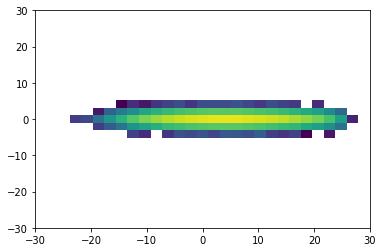

In [494]:
_ = plt.hist2d(x_0[:-1], u_res_poly, bins=[np.linspace(-30, 30, 30), 
                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))

In [516]:
poly_add.corr * 0 + poly_add.res_sd * np.sqrt(1 - poly_add.corr ** 2) * np.random.normal()

0.24254290438043938

In [545]:
ann_res = SubModelANNRes(noise_sd=2.4, verbose=1)

In [546]:
ann_res.fit(x_0.reshape(-1, 1), u_0)

       mean       std
0  4.562264  7.636144
Epoch 1/10
399600/399600 [==============================] - 2s - loss: 17.9560     
Epoch 2/10
399600/399600 [==============================] - 1s - loss: 5.7671     
Epoch 3/10
399600/399600 [==============================] - 1s - loss: 5.7481     
Epoch 4/10
399600/399600 [==============================] - 1s - loss: 5.7308     
Epoch 5/10
399600/399600 [==============================] - 1s - loss: 5.7168     
Epoch 6/10
399600/399600 [==============================] - 1s - loss: 5.7050     
Epoch 7/10
399600/399600 [==============================] - 1s - loss: 5.6951     
Epoch 8/10
399600/399600 [==============================] - 1s - loss: 5.6862     
Epoch 9/10
399600/399600 [==============================] - 1s - loss: 5.6776     
Epoch 10/10
399600/399600 [==============================] - 1s - loss: 5.6700     
Epoch 1/10
399599/399599 [==============================] - 3s - loss: 19.8313     
Epoch 2/10
399599/399599 [==============

In [549]:
res_init = np.array([0])
u_mean_ann = np.zeros(x_0.size - 1)
u_res_ann = np.zeros(x_0.size - 1)
for i in range(x_0.size - 1):
    u_mean_ann[i], u_res_ann[i] = ann_res.predict(np.array([[x_0[i]]]), res_init)
    res_init[:] = u_res_ann[i]
    if i % 100 == 0:
        print(i, u_mean_ann[i], u_res_ann[i])

0 8.86575126648 -1.14570701122
100 6.53141069412 -0.592017769814
200 -3.74393725395 0.988215565681
300 6.55561542511 0.101933240891
400 9.26555252075 -0.575161218643
500 -2.4131090641 -0.247351691127
600 -5.50979471207 0.807488322258
700 7.63933086395 0.0575396865606
800 1.97027170658 -1.58714020252
900 4.08388519287 1.2332662344
1000 1.75930988789 -0.262644827366
1100 -5.91520023346 -0.121865049005
1200 9.14710426331 -1.83019328117
1300 8.31276893616 2.04848265648
1400 -3.59755945206 -0.682755351067
1500 -4.01666927338 1.42116761208
1600 4.92536258698 -1.13818001747
1700 9.81794452667 1.01153242588
1800 6.29825782776 -0.148058280349
1900 6.95765972137 0.24249945581
2000 -3.1614522934 0.554674208164
2100 2.34455561638 0.978710055351
2200 9.72345924377 0.0345983356237
2300 4.98402357101 1.38751351833
2400 9.60771656036 1.28859484196
2500 4.80767965317 0.63739079237
2600 -5.37665987015 0.628092288971
2700 9.01825046539 0.173471018672
2800 -4.21242856979 -0.190972998738
2900 11.1079463959

23600 6.30065965652 0.100069850683
23700 9.18944644928 -1.37110102177
23800 4.07958078384 0.542160272598
23900 9.73383998871 -1.07704937458
24000 9.82461547852 -0.361628234386
24100 9.02799510956 0.168530076742
24200 4.98539829254 -0.636439621449
24300 6.61803913116 -1.25430774689
24400 -3.72492909431 1.69031119347
24500 5.31772136688 -0.193810686469
24600 1.25722241402 -1.32334601879
24700 11.2568511963 -0.368931889534
24800 7.39554548264 -1.27829957008
24900 5.75200033188 -0.115079328418
25000 4.83428812027 1.46074700356
25100 0.198165118694 0.714563071728
25200 9.3623046875 -0.4723341465
25300 -0.384965747595 0.361136257648
25400 9.69168567657 0.108197137713
25500 9.26390457153 -0.262669205666
25600 -2.81624984741 0.434478461742
25700 8.31984901428 0.34965211153
25800 8.13857841492 -1.8253878355
25900 2.69020700455 -0.0346623063087
26000 -2.21787047386 -1.54222142696
26100 -2.90576076508 0.844525098801
26200 7.26342391968 1.0049892664
26300 0.508832216263 0.878803491592
26400 3.5096

46900 2.31625819206 -0.221395090222
47000 5.4279756546 -1.417314291
47100 10.7803087234 1.76780748367
47200 2.2599029541 0.0554297417402
47300 3.50195193291 0.766569018364
47400 8.08276844025 0.96048104763
47500 7.25834989548 -0.732570528984
47600 9.75096130371 0.190778970718
47700 3.26846790314 0.310579359531
47800 0.0889187455177 0.495039761066
47900 6.64741182327 0.225273877382
48000 9.31280517578 0.275074899197
48100 9.85874843597 -0.487418830395
48200 -4.26567029953 0.414326965809
48300 10.7744855881 -0.863056540489
48400 4.4388012886 0.0891171842813
48500 2.55141019821 0.789916038513
48600 5.03019380569 -0.676308870316
48700 10.4843425751 0.125226408243
48800 3.35717487335 -1.43759739399
48900 -5.97733020782 0.510861635208
49000 1.70909774303 1.13742899895
49100 8.59548282623 -1.40121006966
49200 10.257516861 -1.54598736763
49300 1.43715488911 0.615945458412
49400 3.68132638931 -0.468487977982
49500 0.463134199381 2.33912348747
49600 3.91624188423 -0.265862464905
49700 1.78691411

70000 -4.04227113724 -0.53143286705
70100 7.27670526505 -0.105127289891
70200 9.44654560089 0.0510510131717
70300 -0.285802036524 -0.725249767303
70400 7.99961853027 -0.193326875567
70500 6.05468940735 -1.53660988808
70600 -0.857690930367 0.764920949936
70700 3.53023672104 0.511852741241
70800 9.60702896118 0.161040648818
70900 7.82692289352 0.615014851093
71000 -2.81039953232 1.17168724537
71100 10.4388465881 -0.469345092773
71200 -1.56941854954 -0.0277528315783
71300 2.06480884552 -1.65095555782
71400 -1.23003971577 0.896982491016
71500 5.98781251907 0.156059458852
71600 7.51484918594 -0.0714673548937
71700 7.68028497696 -0.686766088009
71800 6.43992185593 0.143874809146
71900 -2.94536662102 0.265999734402
72000 8.13743877411 -0.559831738472
72100 6.48489999771 1.57700109482
72200 -3.42808413506 -1.29021191597
72300 2.62295913696 -0.453547775745
72400 8.75067043304 0.0497684925795
72500 8.18852043152 -0.206530466676
72600 9.08349609375 0.284763157368
72700 5.58728075027 -2.4612963199

93100 0.4789480865 -0.646080970764
93200 2.48046302795 -1.47786796093
93300 3.01345682144 -0.237422481179
93400 1.56173360348 2.82501077652
93500 10.0017194748 -0.00788895785809
93600 1.85662674904 1.2950450182
93700 10.2153720856 -0.255471885204
93800 3.52953958511 -0.956232070923
93900 6.204682827 1.09957122803
94000 10.6904582977 1.6083432436
94100 -2.52620220184 0.797815680504
94200 -6.90430021286 0.795956492424
94300 3.19137144089 -0.232738807797
94400 11.0673103333 0.837070822716
94500 4.59867238998 0.221678942442
94600 1.79318296909 0.533434450626
94700 -2.146910429 2.03264498711
94800 -2.22446155548 0.221834301949
94900 5.15452814102 -0.387624800205
95000 7.76161193848 2.21072006226
95100 5.71385335922 -0.311386108398
95200 5.40024852753 -0.143976822495
95300 10.2332057953 0.752759158611
95400 -1.33273661137 0.206596568227
95500 4.82923555374 0.0584973841906
95600 7.56000518799 0.0281757265329
95700 5.82989501953 0.806405246258
95800 4.32766342163 -0.28956258297
95900 10.968427

115900 -1.87472403049 -1.34475696087
116000 6.99713754654 -0.164736643434
116100 6.60210704803 -0.517171919346
116200 2.7104306221 0.874070763588
116300 11.3776512146 -0.349627077579
116400 -1.08571982384 -1.72763597965
116500 3.32763051987 -0.23962675035
116600 9.03469181061 1.58309316635
116700 2.35364985466 -1.83981430531
116800 -3.76621484756 0.655584454536
116900 1.2141854763 -1.75086081028
117000 6.25593185425 1.77007842064
117100 5.92332601547 0.393189907074
117200 9.61059951782 2.07660865784
117300 7.19862604141 -0.602201044559
117400 6.09036493301 -0.182033017278
117500 1.29510474205 0.254096269608
117600 10.1903686523 -1.83225512505
117700 -3.3132276535 -1.35457003117
117800 -1.08020997047 1.15606987476
117900 10.547498703 -0.842793762684
118000 -2.26624727249 -0.625386893749
118100 1.98852598667 -0.122188135982
118200 4.93579387665 0.790244936943
118300 2.77534866333 0.0270621925592
118400 -2.61752486229 -0.535142600536
118500 8.09508991241 -0.196408286691
118600 2.115400791

138500 0.614059507847 0.428463637829
138600 6.37893104553 1.67839539051
138700 5.59334564209 -0.00314389169216
138800 -0.483501166105 0.0495223104954
138900 2.75012493134 -0.899282574654
139000 8.47076702118 0.955386400223
139100 8.40964794159 -1.23192715645
139200 -0.0747218132019 -0.96954369545
139300 8.52276134491 0.658146381378
139400 -0.252656847239 1.62571680546
139500 9.84860992432 1.54790818691
139600 10.984041214 0.904436588287
139700 4.48453950882 0.192636296153
139800 8.01658725739 0.332646965981
139900 9.44165706635 0.101287171245
140000 9.38859653473 1.34722459316
140100 5.34215545654 0.0970903784037
140200 1.85014283657 0.305619359016
140300 5.64775085449 0.398101449013
140400 8.22067737579 -1.96802914143
140500 9.68281650543 0.503894805908
140600 8.57468318939 0.438747227192
140700 5.502617836 1.19280791283
140800 -3.15690517426 -0.238475754857
140900 3.34502243996 1.08157432079
141000 -1.37502253056 0.0443439036608
141100 10.2933158875 -0.881987690926
141200 0.052499592

161000 6.73077058792 1.95364999771
161100 10.256193161 -0.46408033371
161200 6.22455453873 -0.287066459656
161300 11.7506437302 -0.69534021616
161400 5.27185249329 0.246478378773
161500 2.62953352928 0.45783662796
161600 8.91444587708 -0.483619689941
161700 3.7127225399 -0.498106956482
161800 10.0491485596 0.945178866386
161900 -0.239554792643 -0.0352677404881
162000 1.42965090275 0.639525949955
162100 -2.45154237747 0.387963354588
162200 10.5664567947 0.48158198595
162300 6.51232004166 0.0888382419944
162400 -1.35111510754 0.669510126114
162500 7.41219711304 0.196431666613
162600 -0.0277114808559 0.359465777874
162700 -4.06839990616 -0.685915112495
162800 7.65989112854 0.549393236637
162900 10.2596292496 -1.21822154522
163000 9.59141159058 0.577951669693
163100 6.90259981155 0.438708364964
163200 5.13862466812 0.252894937992
163300 -1.32217550278 0.0227840542793
163400 -4.211581707 1.36001932621
163500 10.2037258148 0.136310324073
163600 2.91243314743 0.557183146477
163700 -2.40822052

183500 5.31063699722 -0.786241173744
183600 0.497916519642 -1.06349670887
183700 5.12321424484 1.275603652
183800 2.50800514221 -0.342066168785
183900 6.21157693863 0.817975997925
184000 6.08579921722 1.1155333519
184100 5.45548295975 -0.190569594502
184200 9.02358055115 0.435001313686
184300 8.45261573792 0.295918643475
184400 -3.27741980553 0.154928103089
184500 5.9649310112 -1.11294043064
184600 0.446874260902 -0.386813879013
184700 10.1769380569 -0.0658687055111
184800 -5.34762525558 0.819373071194
184900 3.3920955658 -1.49965417385
185000 8.44261741638 -1.04975521564
185100 10.6427621841 0.0968674272299
185200 10.5456180573 0.0242544412613
185300 4.81257724762 -1.32709133625
185400 -2.85191059113 -2.02134108543
185500 1.20657539368 1.73814952374
185600 9.56910800934 0.852638959885
185700 8.40284156799 -0.302236437798
185800 1.65895497799 -0.531378984451
185900 -1.07394206524 0.102637693286
186000 4.85759305954 -0.303373813629
186100 -6.23151540756 0.977504730225
186200 -5.43843173

206000 10.0474300385 0.703673124313
206100 11.6572360992 0.0381350964308
206200 0.22353297472 -0.0278511941433
206300 4.86682510376 0.268951833248
206400 8.80758285522 -0.685523211956
206500 10.2964076996 -0.828029513359
206600 5.84829950333 -1.04635596275
206700 -1.9456230402 -0.968493700027
206800 -3.3903503418 -1.47866284847
206900 5.58257055283 1.07141757011
207000 2.05323147774 -0.795964062214
207100 9.65612220764 1.22528791428
207200 -1.44157087803 0.526231348515
207300 -6.60389757156 0.959992706776
207400 9.47937774658 -0.932361960411
207500 9.85281944275 1.60666835308
207600 3.5697426796 -0.652293980122
207700 1.80954134464 0.261521816254
207800 9.13279819489 0.461225569248
207900 5.65078687668 -1.01826632023
208000 8.19382762909 0.338660597801
208100 -1.50195276737 0.587275385857
208200 6.85160970688 -0.507326722145
208300 10.5990867615 0.493899405003
208400 6.84625387192 0.936061501503
208500 -6.00954008102 0.0628891140223
208600 -3.99153423309 2.07827734947
208700 6.41076612

228500 -2.09233880043 0.681040406227
228600 -3.68155288696 0.941882133484
228700 9.86984634399 0.10831104219
228800 2.35007548332 0.21481461823
228900 -0.122184604406 1.69448101521
229000 3.14132070541 1.18676388264
229100 8.25801944733 0.54930961132
229200 6.09499311447 -1.13720583916
229300 1.21485316753 -0.685507416725
229400 -3.66159701347 0.116115689278
229500 9.44496536255 0.0301434099674
229600 9.26216888428 -0.167396143079
229700 1.56367862225 -0.74410367012
229800 0.409623891115 -1.06148445606
229900 2.09802269936 0.852753281593
230000 10.5073537827 0.758688747883
230100 4.48058843613 -0.312243878841
230200 -4.10763120651 -0.36351531744
230300 2.69453525543 1.42778909206
230400 9.33737182617 -1.46604752541
230500 9.2634973526 -0.135323420167
230600 -2.09300160408 0.311810851097
230700 -3.85646247864 -1.8016153574
230800 2.69067287445 -0.485562622547
230900 7.39207029343 0.194233104587
231000 9.72519111633 1.09595191479
231100 9.57292366028 -1.06663417816
231200 10.1983127594 1

251100 -2.47028613091 0.640817403793
251200 2.35725736618 1.05939161777
251300 10.353805542 0.710559308529
251400 8.45852661133 0.944830775261
251500 9.0697555542 0.414304554462
251600 8.96164512634 -0.144927337766
251700 3.59777259827 -1.37454736233
251800 9.22728061676 0.980658054352
251900 2.79705572128 0.990788638592
252000 2.2665014267 0.214747965336
252100 4.39998292923 -1.20766115189
252200 0.490352779627 -0.722094774246
252300 9.11987113953 0.60425144434
252400 8.18394565582 -0.55876159668
252500 5.37033414841 -0.635081589222
252600 6.96834039688 0.67259645462
252700 7.14936590195 4.17189884186
252800 8.51055717468 -0.785618424416
252900 11.0448436737 1.014508605
253000 7.52133321762 0.68165409565
253100 9.58364868164 0.623420655727
253200 -3.5673763752 0.551672577858
253300 -4.17308664322 0.631086826324
253400 -2.16871976852 -0.0152020007372
253500 -0.711557269096 -1.06823348999
253600 -3.99149656296 0.0356907695532
253700 9.53194618225 0.258710324764
253800 4.35918664932 -0.4

273600 10.7864456177 -0.432203888893
273700 4.01164197922 0.183912187815
273800 7.88720035553 0.752827525139
273900 7.977206707 -0.079143434763
274000 6.74790000916 1.23522174358
274100 5.62987709045 -0.0836794227362
274200 8.85790634155 1.6427975893
274300 -1.21991693974 -0.0734567791224
274400 0.152327120304 0.223741486669
274500 6.49467182159 0.586869239807
274600 8.22771453857 1.42622029781
274700 -7.20655012131 0.94658178091
274800 -0.408946961164 0.297356188297
274900 6.03659486771 -0.577396094799
275000 10.9689674377 0.464274764061
275100 -1.93379366398 -0.575987577438
275200 9.29394435883 -1.65186393261
275300 -5.15980672836 -1.00698709488
275400 9.61779594421 0.992636561394
275500 -3.13711452484 -0.544316053391
275600 -0.0301624536514 -0.458766341209
275700 -3.42182540894 -0.164494410157
275800 9.8141784668 -0.565800905228
275900 -2.8213570118 1.17338073254
276000 10.1062850952 0.51303768158
276100 8.19010639191 -1.42611122131
276200 1.49252068996 -1.09368741512
276300 -1.4612

296200 -5.57337427139 0.0062208622694
296300 1.79808008671 -0.817107915878
296400 7.27862882614 -0.0341413170099
296500 7.32429933548 -0.204372808337
296600 -2.01841282845 0.544383168221
296700 11.6521043777 1.82440340519
296800 -4.75534296036 -0.402013063431
296900 0.311145484447 -0.207966998219
297000 9.34311771393 1.67944860458
297100 -0.124241054058 0.498782992363
297200 10.3218584061 -0.219260528684
297300 8.26322174072 -0.257509946823
297400 0.41603282094 1.5961728096
297500 8.66567611694 0.660075545311
297600 9.74568939209 0.322762012482
297700 8.96361160278 -0.115139618516
297800 0.361544191837 -0.921407699585
297900 5.70214605331 -0.569240808487
298000 5.95340299606 -0.378743648529
298100 2.21775174141 -1.06575417519
298200 2.85851573944 -0.38326561451
298300 -0.471955388784 -1.84438955784
298400 11.7727556229 0.130184352398
298500 -0.570754885674 -0.238793805242
298600 -4.37440252304 0.270201086998
298700 6.98541212082 -0.494261682034
298800 -2.49529790878 1.80485618114
29890

318800 -1.20737946033 1.13862645626
318900 8.76450443268 0.234176650643
319000 7.73063802719 -0.281312406063
319100 2.84155225754 -0.865238785744
319200 2.1615858078 1.16932284832
319300 11.641453743 -0.49839413166
319400 7.60655260086 -0.664125084877
319500 0.042544990778 -0.0207093954086
319600 9.17534542084 -2.04977154732
319700 8.95659637451 0.799017727375
319800 6.88130998611 -0.0343445390463
319900 -2.67486095428 -1.90018808842
320000 11.2311038971 0.0302546471357
320100 -4.23094415665 0.271566390991
320200 11.1073589325 -0.640904009342
320300 0.511460781097 -0.335826933384
320400 7.75905847549 0.16922198236
320500 9.3392791748 1.01198399067
320600 6.98994874954 1.25657248497
320700 4.93887710571 0.827121853828
320800 -4.01227712631 3.12952446938
320900 -3.62271046638 0.812831044197
321000 6.53076934814 -0.563274025917
321100 6.50713348389 -0.274873077869
321200 8.48257637024 -0.145184203982
321300 3.95569062233 0.245941355824
321400 10.7886018753 1.23602569103
321500 1.983063817

341300 9.24700546265 -0.19017995894
341400 -3.89630174637 -0.0965140908957
341500 9.81660938263 -0.722256422043
341600 9.30563735962 -0.388114869595
341700 7.98859786987 -2.01839113235
341800 2.67800307274 0.225680202246
341900 7.07634496689 -0.955773949623
342000 0.104738742113 -0.453481912613
342100 8.05732154846 0.393445014954
342200 -0.319502681494 -0.0429045557976
342300 9.24168491364 1.15308582783
342400 0.219945520163 -0.0888002663851
342500 4.94202899933 0.894760131836
342600 3.2098698616 -1.78287041187
342700 10.5953998566 0.355984985828
342800 8.44105529785 -1.48538017273
342900 5.23341703415 -1.62538278103
343000 9.22119998932 0.350700259209
343100 10.2256269455 -1.12083220482
343200 8.49291706085 0.56384819746
343300 -2.99621081352 -0.673445940018
343400 -5.57879829407 -0.747339427471
343500 -1.69048249722 1.57505857944
343600 -6.19963645935 -0.0231383740902
343700 5.53193330765 0.000125706195831
343800 9.7496137619 0.45332211256
343900 2.25133347511 -0.913782477379
344000 

363900 5.82217359543 -0.201273486018
364000 -4.52398538589 1.27971053123
364100 6.5610165596 0.360195428133
364200 8.41042804718 1.70075118542
364300 -2.06875371933 -0.567958891392
364400 9.10639953613 1.65513169765
364500 0.938049316406 -0.87455034256
364600 8.08945941925 -0.0287922173738
364700 -2.55310821533 -0.875231146812
364800 6.91165685654 0.778652846813
364900 6.44268941879 -0.985591053963
365000 -4.71986150742 -2.78821849823
365100 0.661165595055 0.943686842918
365200 4.82710075378 0.620408892632
365300 -1.58628690243 1.5714482069
365400 -4.65332174301 -0.101188883185
365500 2.42640733719 0.104306891561
365600 -1.13042581081 -2.16407752037
365700 10.8557100296 -0.211586788297
365800 -1.68382120132 0.320330202579
365900 -2.21821928024 -0.711758613586
366000 -1.83032906055 -0.0738993138075
366100 -4.27388858795 -0.178728833795
366200 -0.950559616089 -1.72707700729
366300 9.46124839783 1.8024033308
366400 3.9916446209 0.298952281475
366500 -2.90211057663 0.157840624452
366600 4.

386500 10.3484659195 0.910560011864
386600 -0.62101817131 -0.478193998337
386700 8.41108131409 -0.370103180408
386800 7.52162599564 0.994827032089
386900 10.6981391907 -0.163513556123
387000 -3.27644586563 0.205187901855
387100 6.1655049324 0.425507843494
387200 -3.07584810257 1.66101002693
387300 -5.66646146774 0.687415540218
387400 5.52192258835 -1.14372968674
387500 4.61827850342 0.457418084145
387600 10.0331478119 -0.609764039516
387700 -5.11498117447 0.195543512702
387800 9.212474823 0.198485717177
387900 0.836797475815 -0.429198503494
388000 10.694272995 0.348026931286
388100 -0.875267386436 -1.28090441227
388200 0.0138816833496 -0.0290799587965
388300 0.968048810959 0.072993054986
388400 6.087911129 -3.15235114098
388500 0.855064511299 -0.152500227094
388600 0.756758093834 -0.546344280243
388700 -1.00943756104 -3.59259772301
388800 8.22326564789 -0.625346243382
388900 7.27548599243 0.743249177933
389000 11.5814981461 2.21994185448
389100 -6.09560489655 0.297754704952
389200 -4.1

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


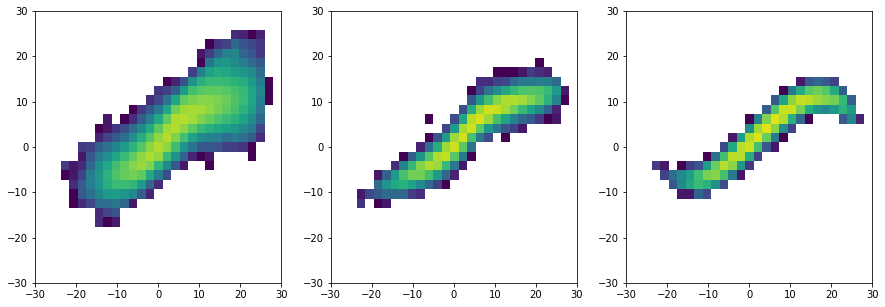

In [556]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
_ = plt.hist2d(x_0[:-1], u_0[:-1],bins=[np.linspace(-30, 30, 30), 
                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
plt.subplot(1, 3, 2)
_ = plt.hist2d(x_0[:-1], u_mean_ann + u_res_ann, bins=[np.linspace(-30, 30, 30), 
                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))
plt.subplot(1,3 ,3)
_ = plt.hist2d(x_0[:-1], u_mean_poly + u_res_poly, bins=[np.linspace(-30, 30, 30), 
                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=50000, norm=LogNorm(1, 50000))

(array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),
 array([-10.54649353, -10.32114887, -10.09580421,  -9.87045956,
         -9.6451149 ,  -9.41977024,  -9.19442558,  -8.96908092,
         -8.74373627,  -8.51839161,  -8.29304695,  -8.06770229,
         -7.84235764,  -7.61701298,  -7.39166832,  -7.16632366,
         -6.940979  ,  -6.71563435,  -6.49028969,  -6.26494503,
         -6.03960037,  -5.81425571,  -5.58891106,  -5.3635664 ,
         -5.13822174,  -4.91287708,  -4.68753242,  -4.46218777,
         -4.23684311,  -4.01149845,  -3.78615379,  -3.56080914,
         -3.33546448,  -3.11011982,  -2.88477516,  -2.6594305 ,
         -2.43408585,  -2.20874119,  -1.98339653,  -1.75805187,
         -1.53270721,  -1.30736256,  -

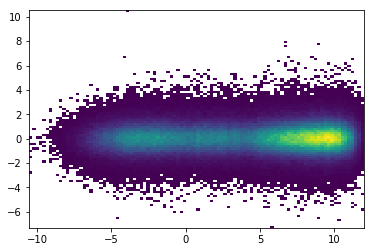

In [570]:
plt.hist2d(u_mean_ann, u_res_ann, bins=100, cmin=1)

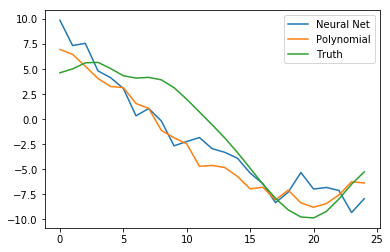

In [597]:
i_start = 25
i_end = 50
plt.plot(u_mean_ann[i_start:i_end] + u_res_ann[i_start:i_end], label="Neural Net")
plt.plot(u_mean_poly[i_start:i_end] + u_res_poly[i_start:i_end], label="Polynomial")
plt.plot(u_0[i_start+1: i_end+1], label="Truth")
plt.legend()

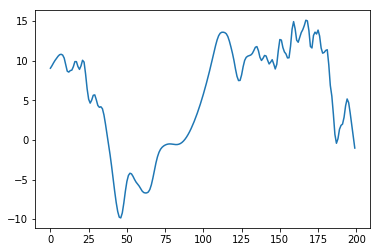